# Prática 7 - Experimentos - Parte II

#Nome: Ricardo França Fernandes do Vale     No. USP: 9293477

Nesta prática, o foco é observar o modelo de classificação, em especial, algumas métricas de interesse para observar sua eficiência para a resolução do problema. Neste relatório serão abordadas questões como testes de hipótese e curvas ROC, a fim de refinar as informações sobre o desempenho para tentar arquitetar maneiras de melhorá-lo. 


## Dataset - Breast Cancer

Como o objetivo da prática é testar uma modelagem de avaliação, o dataset de interesse continua sendo com classes discretas e binarizado por natureza: o dataset Breast Cancer, que, diante de alguns fatores biológicos (atributos) tem como alvo classificar a amostra como tumor benigno ou maligno. Primeiramente, será carregado o dataset; serão utilizados apenas os atributos selecionados a partir da prática anterior:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data = pd.DataFrame(data=np.c_[data['data'], data['target']], 
                          columns=np.r_[data['feature_names'], ['target']])

bc = data[['mean smoothness','mean symmetry', 'worst smoothness','worst texture','target']].copy()
bc.head()

,mean smoothness,mean symmetry,worst smoothness,worst texture,target
0,0.11840,0.2419,0.1622,17.33,0.0
1,0.08474,0.1812,0.1238,23.41,0.0
2,0.10960,0.2069,0.1444,25.53,0.0
3,0.14250,0.2597,0.2098,26.50,0.0
4,0.10030,0.1809,0.1374,16.67,0.0


### 1. Classificação

Carregada a base de dados, o primeiro passo é realizar a técnica do 10-fold cross validation para obter medidas como acurácia, sensitividade, entre outras, para observar o desempenho da classificação apenas com as métricas mais adequadas. Abaixo encontra-se a função de classificação utilizada.

In [2]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=10, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    #svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em k partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results_actual = {'perceptron':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    results_predicted = {'perceptron':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)

            # realiza predição no conjunto de teste e salva o resultado
            results_actual[c_name] = np.append(y_test, results_actual[c_name])
            results_predicted[c_name] = np.append(y_pred, results_predicted[c_name])

    return results_actual, results_predicted
    

Sendo assim, será aplicado o classificador no conjunto de dados reduzido o 10-fold cross validation. Em seguida, será obtida a matriz de confusão do classificador, de onde serão tiradas as medidas de interesse e exibidas abaixo.

In [91]:
results_actual, results_predicted = classificacao(bc, [0,1,2,3], 4, folds=10, plot=False)

from sklearn.metrics import confusion_matrix

classifiers = results_predicted.keys()

print('Dada a configuração da matriz: ')
print('|----------|')
print('| VP\tFN |')
print('| FP\tVN |')
print('|----------|\n\n')

alfa = 0.29291
for c in classifiers:
    print('Para o classificador: ', c)
    tp, fn, fp, tn = confusion_matrix(results_actual[c], results_predicted[c]).ravel()

    print('Medida de desempenho - 10-fold cross validation')
    precision = tp/float(tp+fp)
    revoke = tp/float(tp+fn)
    print('Acurácia: ', (tp+tn)/float(tp+fp+tn+fn))
    print('Precisão: ', precision)
    print('Revocação: ', revoke)
    print('Especificidade: ', tn/float(tn+fp))
    print('Media harmonica ponderada: ', ((1+alfa)*precision*revoke)/(alfa*precision+revoke))
    print('Medida-F1: ', 2/((1/precision)+(1/revoke)))
    print('\n\n')

Dada a configuração da matriz: 
|----------|
| VP	FN |
| FP	VN |
|----------|


Para o classificador:  3nn
Medida de desempenho - 10-fold cross validation
Acurácia:  0.6959578207381371
Precisão:  0.5951219512195122
Revocação:  0.5754716981132075
Especificidade:  0.7675070028011205
Media harmonica ponderada:  0.5905534964611348
Medida-F1:  0.5851318944844125



Para o classificador:  dt
Medida de desempenho - 10-fold cross validation
Acurácia:  0.7627416520210897
Precisão:  0.7150837988826816
Revocação:  0.6037735849056604
Especificidade:  0.8571428571428571
Media harmonica ponderada:  0.68641474142432
Medida-F1:  0.6547314578005116



Para o classificador:  5nn
Medida de desempenho - 10-fold cross validation
Acurácia:  0.6924428822495606
Precisão:  0.592964824120603
Revocação:  0.5566037735849056
Especificidade:  0.773109243697479
Media harmonica ponderada:  0.5843170421160081
Medida-F1:  0.5742092457420924



Para o classificador:  perceptron
Medida de desempenho - 10-fold cross valid

Dentre os valores obtidos, é possível observar a peculiaridade de cada métrica obtida. A acurácia não chega a 80% em nenhum dos casos, mas tem um desempenho notavelmente melhor para os classificadores que utilizam árvore de decisão ou cálculo de distância, o que é compreensível, por se tratar de um problema binário; inclusive, a maior acurácia é obtida pelas árvores de decisão. O mesmo efeito dos classificadores é observado na precisão e na revocação. 

O cenário muda diante da especificidade, em que o perceptron, que possuía os menores valores até então, atinge os maior valor diante dos outros classificadores. A especificidade é definida como a porcentagem de exemplos negativos classificados como negativos, o que indica que o perceptron seria o melhor classificador para identificar tumores benignos.

Porém, ao calcular-se a média harmônica e a medida-f1 que balanceiam duas medidas para observar a quantidade de acertos nas predições de classificações positivas, o padrão das demais medidas exceto a especificidade é seguido, o que permite concluir que as árvores de decisão são o melhor classificador, nesta aplicação, para descobrir tumores negativos. 

### 2. Curva ROC e área sob a curva

A próxima observação a ser feita sobre o modelo de predição é o cálculo da curva ROC, uma medida de desempenho da classificação. Serão apenas utilizados os classificadores:
- Decision Trees;
- 7nn.
Devido ao fato de terem atingidos as maiores acurácias e serem os mais precisos diante do problema de predizer tumores malignos.

Para observar a curva ROC, deve-se reescrever a função de classificação para retornar scores. 

In [52]:
from sklearn.model_selection import train_test_split

def classificacao_ROC(data, columns, target):
    # inicializa os modelos com os parâmetros solicitados
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [dt,_7nn]
    clfs_names = ['dt','7nn']
    
    results = {'dt':(),'7nn':()}
    
    for c,c_name in zip(clfs, clfs_names):
        # inicializando os holdouts
        x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,columns],data.iloc[:,target],
                                                            test_size=0.2)
        clf = c.fit(X=x_train, y=y_train)

        # valores predito pelo classificador
        # escrito dessa forma para retornar a probabilidade
        y_pred = clf.predict_proba(x_test)
        # rótulos verdadeiros convertidos para array
        y_test = np.array(y_test)
        
        #Concatenando valores
        results[c_name] = (y_pred, y_test)
    
    return results

Sendo assim, os scores serão obtidos para que seja realizado o cálculo da curva ROC e a área sob a curva ROC.

Curva ROC para a Decision Tree


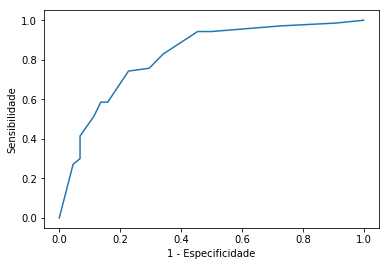

Curva ROC para o 7NN


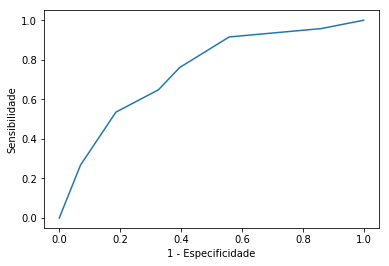



AUC da Deicision Tree:  0.8212662337662338
AUC do 7nn:  0.7438584998362266


In [73]:
from sklearn.metrics import roc_curve, roc_auc_score

clf_10_fold_cv = classificacao_ROC(bc, [0,1,2,3], 4)

# Obtendo os valores preditos e reais para plotar na curva ROC
dt_pred = clf_10_fold_cv['dt'][0]
dt_test = clf_10_fold_cv['dt'][1]
_7nn_pred = clf_10_fold_cv['7nn'][0]
_7nn_test = clf_10_fold_cv['7nn'][1]

# Plotando a curva roc
# Decision Tree
print('Curva ROC para a Decision Tree')
fpr, tpr, thresholds = roc_curve(dt_test, dt_pred[:,1])
plt.plot(fpr,tpr)
plt.xlabel("1 - Especificidade")
plt.ylabel("Sensibilidade")
plt.show()

# 7NN
print('Curva ROC para o 7NN')
fpr, tpr, thresholds = roc_curve(_7nn_test, _7nn_pred[:,1])
plt.xlabel("1 - Especificidade")
plt.ylabel("Sensibilidade")
plt.plot(fpr,tpr)
plt.show()

# Calculando a área sobre a curva ROC
print('\n')
print('AUC da Deicision Tree: ', roc_auc_score(dt_test, dt_pred[:,1]))
print('AUC do 7nn: ', roc_auc_score(_7nn_test, _7nn_pred[:,1]))

### 3. Interpretação dos valores da curva ROC e AUC

Dada a curva de aprendizado ROC de ambos os classificadores, a área sob a curva, que indica uma estimativa de desempenho reforça a ideia de que a **árvore de decisão** possui um melhor desempenho por causa de sua área maior.

### 4. Teste de hipótese

Por fim, será realizado um teste de hipótese para observar, sem um olhar subjetivo, a comparação entre dois classificadores e poder interpretar qual a melhor, dado um intervalo de confiança. Novamente, os classificadores a serem comparados pelo teste de hipótese serão o 7nn e a decision tree.

O teste de hipótese escolhido será o t-test não pareado com 5% de nível de significância, sendo que a hipótese nula (H0) é que a média de erro da decision tree seja igual à média de erro do 7nn. Para isso, a função de classificação será reescrita para retornar os resultados brutos (como nas primeiras práticas) e, então, aplicar o teste de hipótese.

In [3]:
from sklearn.metrics import mean_squared_error
from numpy import mean, std

import warnings
warnings.filterwarnings('ignore')

def classificacao_th(data, columns, target, score, score_name, folds=10):
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [dt, _7nn]
    clfs_names = ['dt', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'dt':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
    
    return results

In [5]:
# Recriação da função utilizada pelo teste de hipótese
def pen_falso_negativo(y_true, y_pred):
    import numpy as np
    count = 0
    for i,j in enumerate(y_pred):
        if y_true[i] == 0 and j == 1:
            count += 2
        elif y_true[i] == 1 and j == 0:
            count += 1
    return count/len(y_true)

# Aplicação da classificação
clf_test = classificacao_th(bc, [0,1,2,3], 4, pen_falso_negativo, 'Medida de falso negativo', folds=10)

# Aplicação do teste de hipótese
from scipy import stats
# importando a função do t test para amostrar independentes
from scipy.stats import ttest_ind
np.random.seed(12345678)

print(ttest_ind(clf_test['dt'], clf_test['7nn']))

Ttest_indResult(statistic=-1.3810344922600692, pvalue=0.18417494348609428)
[0.3684210526315789, 0.38596491228070173, 0.5087719298245614, 0.5263157894736842, 0.3157894736842105, 0.14035087719298245, 0.38596491228070173, 0.3684210526315789, 0.42105263157894735, 0.5]


**Conclusão:** Como pode ser observado no p-valor, cujo valor é (levemente) maior que o nível de significância (alpha) igual à 5%, a hipótese levantada não deve ser rejeitada pois não há certeza em relação a igualdade das médias de erro dos dois classificadores. A hipótese de que a decision tree seja, de fato, o melhor classificador para o problema também não é descartada já que o valor estatístico é negativo, indicando um valor mais à esquerda da distribuição.